## CPR Waveform Segmentation - PostDoc Application

**Project Goal:** Develop a machine learning model to accurately identify diastolic and systolic points within arterial waveforms obtained during both chest compressions and normal heartbeats.

**Background:** Analyzing these waveforms is crucial for monitoring CPR effectiveness. Standard peak detection methods can be unreliable during compressions, necessitating a more robust approach.

**Data:** This notebook utilizes a dataset of 6,800 labeled waveform segments.

Let's first load the data

In [1]:
import numpy as np

try:
    # Attempt to load the data
    data = np.load('data/sample_data.npy')

    # Print the shape of the loaded data to verify it's loaded correctly
    print("Data loaded successfully!")
    print("Shape of the loaded data:", data.shape)

    # You can now work with the 'data' variable. For example, print the first few elements:
    # print(data[:5])

except FileNotFoundError:
    print("Error: 'sample_data.npy' not found. Please make sure the file exists in the current directory.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Data loaded successfully!
Shape of the loaded data: (2, 6800, 400)


In [2]:
input_data = data[0,:,:]
output_data = data[1,:,:].astype(int)
signal_freq = 200  # Hz
CLASS_LABEL = {
    0: "Nothing",
    1: "Diastolic (compression)",
    2: "Systolic (compression)",
    3: "Diastolic (normal)",
    4: "Systolic (normal)",
}

First lets split up Chest compression and Normal heartbeat data so we can view some examples

In [3]:
import numpy as np
import pandas as pd

# Building database for chest compression
idx_cc = []         
for i in range(output_data.shape[0]):
    if np.any(output_data[i, :] == 1) or np.any(output_data[i, :] == 2):
        idx_cc.append(i)
# Building database for normal heartbeat
idx_nh = []
for i in range(output_data.shape[0]):
    if np.any(output_data[i, :] == 3) or np.any(output_data[i, :] == 4):
        idx_nh.append(i)
#Robustness check
overlap = set(idx_cc) & set(idx_nh)
if overlap:
    print(f"Overlap found! {len(overlap)} common indices.")
    print(sorted(list(overlap))[:20], "...")  # preview first 20
else:
    print("✅ No overlapping indices.")



Overlap found! 6 common indices.
[1439, 3220, 3349, 4031, 5367, 5558] ...


Now visualizing for Chest Compressions

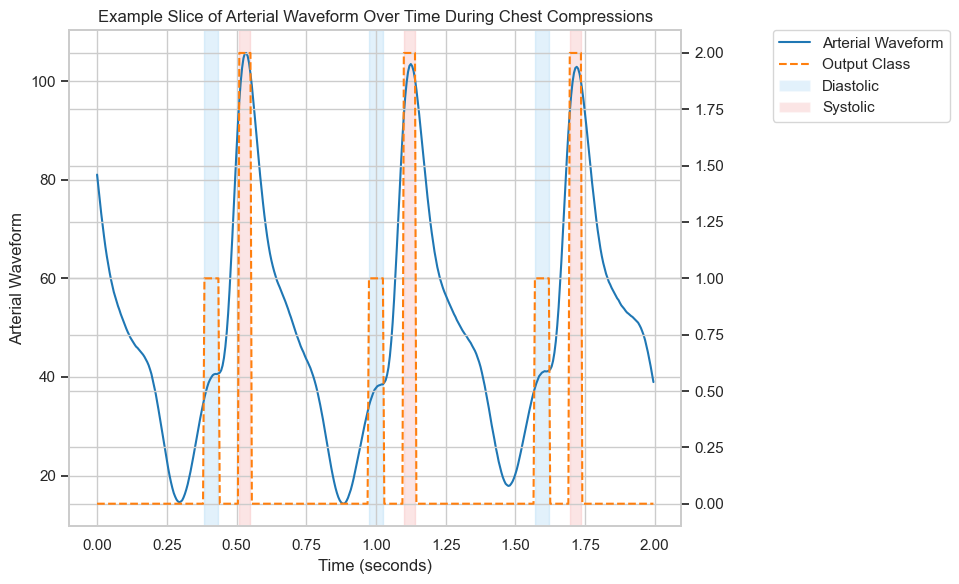

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# ---- Example setup (replace with your actual data) ----
signal_freq = 200  # sampling rate (Hz)
time = np.arange(len(input_data[1, :])) / signal_freq

# ---- Create figure and primary axis ----
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot arterial waveform
sns.lineplot(
    x=time,
    y=input_data[1, :],
    ax=ax1,
    label='Arterial Waveform',
    color='tab:blue'
)

# Secondary y-axis for output class
ax2 = ax1.twinx()
sns.lineplot(
    x=time,
    y=output_data[1, :],
    ax=ax2,
    linestyle='--',
    color='tab:orange',
    # label='Output Class'
)

# ---- Shading function ----
CLASS_LABEL = {1: "Diastolic", 2: "Systolic"}
CLASS_COLOR = {1: "#8EC9F0", 2: "#F29A9A"}  # light blue / light red

def shade_segments(ax, t, y_classes):
    for cid in (1, 2):
        m = (y_classes == cid)
        if not m.any():
            continue
        edges = np.diff(np.r_[False, m, False]).nonzero()[0]
        starts, ends = edges[0::2], edges[1::2]
        for s, e in zip(starts, ends):
            ax.axvspan(t[s], t[e-1], color=CLASS_COLOR[cid], alpha=0.25, zorder=0)

# ---- Call shading AFTER plotting ----
shade_segments(ax1, time, output_data[1, :])

# ---- Custom legend (no duplicates, placed outside) ----
legend_handles = [
    Line2D([], [], color='tab:blue', label='Arterial Waveform'),
    Line2D([], [], color='tab:orange', linestyle='--', label='Output Class'),
    Patch(facecolor=CLASS_COLOR[1], alpha=0.25, label=CLASS_LABEL[1]),
    Patch(facecolor=CLASS_COLOR[2], alpha=0.25, label=CLASS_LABEL[2]),
]

ax1.legend(
    handles=legend_handles,
    loc='upper left',
    bbox_to_anchor=(1.15, 1.0),   # move further right
    borderaxespad=0.,
    frameon=True
)

# ---- Titles and labels ----
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Arterial Waveform")
# ax2.set_ylabel("Output Class")
ax1.set_title("Example Slice of Arterial Waveform Over Time During Chest Compressions")

# plt.subplots_adjust(right=0.75)  # make space for legend
plt.tight_layout()
plt.show()


Now visualizing for Normal Heartbeat

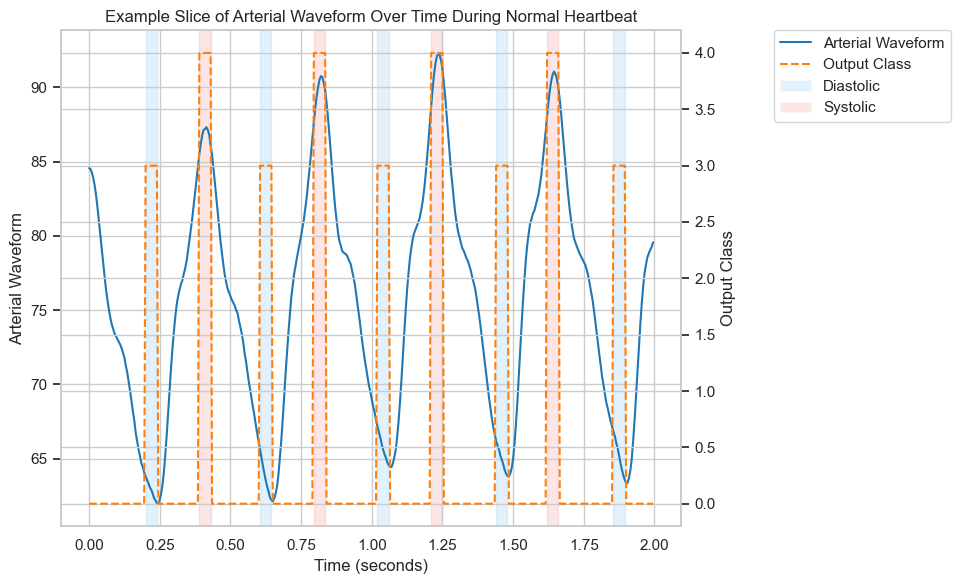

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# ---- Example setup (replace with your actual data) ----
signal_freq = 200  # sampling rate (Hz)
time = np.arange(len(input_data[0, :])) / signal_freq

# ---- Create figure and primary axis ----
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot arterial waveform
sns.lineplot(
    x=time,
    y=input_data[0, :],
    ax=ax1,
    label='Arterial Waveform',
    color='tab:blue'
)

# Secondary y-axis for output class
ax2 = ax1.twinx()
sns.lineplot(
    x=time,
    y=output_data[0, :],
    ax=ax2,
    linestyle='--',
    color='tab:orange',
)

# ---- Shading function ----
CLASS_LABEL = {3: "Diastolic", 4: "Systolic"}
CLASS_COLOR = {3: "#8EC9F0", 4: "#F29A9A"}  # light blue / light red

def shade_segments(ax, t, y_classes):
    for cid in (3, 4):
        m = (y_classes == cid)
        if not m.any():
            continue
        edges = np.diff(np.r_[False, m, False]).nonzero()[0]
        starts, ends = edges[0::2], edges[1::2]
        for s, e in zip(starts, ends):
            ax.axvspan(t[s], t[e-1], color=CLASS_COLOR[cid], alpha=0.25, zorder=0)

# ---- Call shading AFTER plotting ----
shade_segments(ax1, time, output_data[0, :])

# ---- Custom legend (no duplicates, placed outside) ----
legend_handles = [
    Line2D([], [], color='tab:blue', label='Arterial Waveform'),
    Line2D([], [], color='tab:orange', linestyle='--', label='Output Class'),
    Patch(facecolor=CLASS_COLOR[3], alpha=0.25, label=CLASS_LABEL[3]),
    Patch(facecolor=CLASS_COLOR[4], alpha=0.25, label=CLASS_LABEL[4]),
]

ax1.legend(
    handles=legend_handles,
    loc='upper left',
    bbox_to_anchor=(1.15, 1.0),   # move further right
    borderaxespad=0.,
    frameon=True
)

# ---- Titles and labels ----
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Arterial Waveform")
ax2.set_ylabel("Output Class")
ax1.set_title("Example Slice of Arterial Waveform Over Time During Normal Heartbeat")

# plt.subplots_adjust(right=0.75)  # make space for legend
plt.tight_layout()
plt.show()


Let's first make an LSTM that can estimate among the five output classes

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# ----------------------------
# Config
# ----------------------------
WINDOW = 10       # timesteps per window
STRIDE = 1        # slide within each 400-sample patch
N_CLASSES = 5     # {0..4}

# input_data: shape (6800, 400), float
# output_data: shape (6800, 400), ints in {0..4}

# ----------------------------
# Build windows per patch (no cross-boundary windows)
# ----------------------------
Xs, ys = [], []
for x_row, y_row in zip(input_data, output_data.astype(int)):
    # (optional) per-patch normalization
    x = x_row.astype(np.float32)
    x = (x - x.mean()) / (x.std() + 1e-8)

    # make windows inside this 400-sample patch
    idx = np.arange(0, x.shape[0] - WINDOW + 1, STRIDE, dtype=np.int32)
    if idx.size == 0:
        continue
    # windows: (num_win, WINDOW), labels aligned to the last sample of each window
    X_row = np.stack([x[i:i+WINDOW] for i in idx], axis=0)[..., None]  # add feature dim -> (num_win, WINDOW, 1)
    y_row = y_row[idx + WINDOW - 1]

    Xs.append(X_row)
    ys.append(y_row)

X = np.concatenate(Xs, axis=0)
y = np.concatenate(ys, axis=0).astype(np.int64)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (2658800, 10, 1) y shape: (2658800,)


In [ ]:
# Split indices at the patch level, then rebuild windows only for train/val if you want strict separation.
# For simplicity here, we random-split the windows:
rng = np.random.default_rng(42)
perm = rng.permutation(len(X))
split = int(0.8 * len(X))
tr_idx, va_idx = perm[:split], perm[split:]

X_train, y_train = X[tr_idx], y[tr_idx]
X_val,   y_val   = X[va_idx], y[va_idx]

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(32768).batch(256).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(256).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# LSTM model (window=10, univariate)
# ----------------------------
inputs = keras.Input(shape=(WINDOW, 1))
x = keras.layers.LSTM(64)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(N_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
8309/8309 [==============================] - 55s 6ms/step - loss: 0.3116 - acc: 0.8848 - val_loss: 0.2637 - val_acc: 0.8935
Epoch 2/15
8309/8309 [==============================] - 50s 6ms/step - loss: 0.2723 - acc: 0.8924 - val_loss: 0.2575 - val_acc: 0.8953
Epoch 3/15
8309/8309 [==============================] - 50s 6ms/step - loss: 0.2649 - acc: 0.8947 - val_loss: 0.2565 - val_acc: 0.8962
Epoch 4/15
8309/8309 [==============================] - 51s 6ms/step - loss: 0.2586 - acc: 0.8971 - val_loss: 0.2466 - val_acc: 0.9011
Epoch 5/15
2355/8309 [=======>......................] - ETA: 32s - loss: 0.2551 - acc: 0.8986

KeyboardInterrupt: 

Now estimating the peak-to-peak i.e. Systolic to diastolic period for Chest Compressions aggregated across all segments

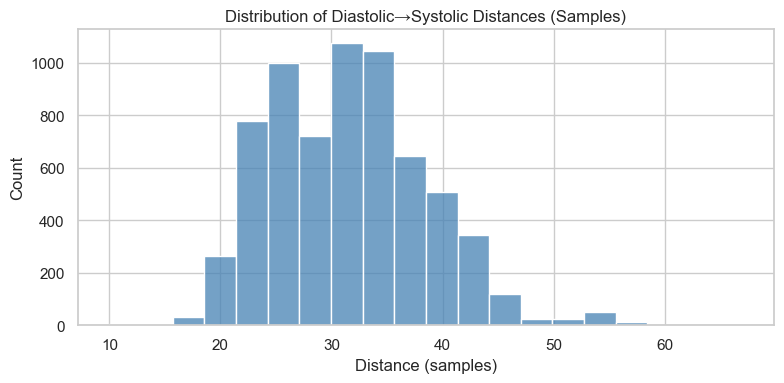

In [ ]:
import numpy as np

Fs = 200.0  # Hz
output_data_cc = output_data[idx_cc, :].astype(int)

all_samples = []
all_seconds = []

for y in output_data_cc:
    d_starts = np.flatnonzero(np.diff((y == 1).astype(np.int8), prepend=0) == 1)
    s_starts = np.flatnonzero(np.diff((y == 2).astype(np.int8), prepend=0) == 1)
    j = np.searchsorted(s_starts, d_starts, side='right')
    valid = j < s_starts.size
    per_cycle_samples = s_starts[j[valid]] - d_starts[valid]
    all_samples.extend(per_cycle_samples)
    all_seconds.extend(per_cycle_samples / Fs)

per_cycle_samples = np.array(all_samples)
per_cycle_seconds = np.array(all_seconds)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.histplot(per_cycle_samples, bins=20, kde=False, color="steelblue")
plt.title("Distribution of Diastolic→Systolic Distances (For Chest Compressions)")
plt.xlabel("Distance (samples)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Similarly for normal heartbeat

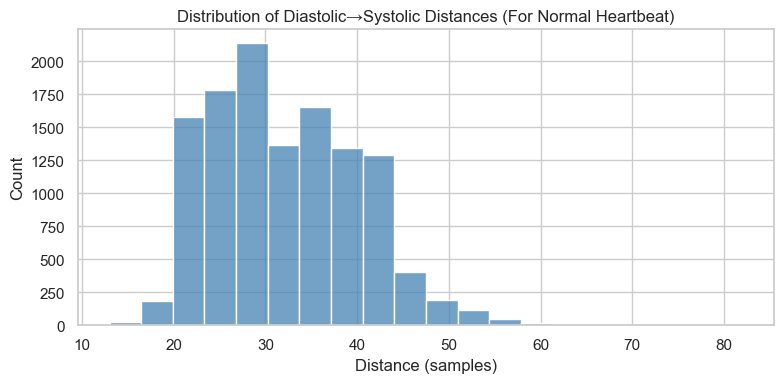

In [15]:
import numpy as np

Fs = 200.0  # Hz
output_data_nh = output_data[idx_nh, :].astype(int)

all_samples = []
all_seconds = []

for y in output_data_nh:
    d_starts = np.flatnonzero(np.diff((y == 3).astype(np.int8), prepend=0) == 1)
    s_starts = np.flatnonzero(np.diff((y == 4).astype(np.int8), prepend=0) == 1)
    j = np.searchsorted(s_starts, d_starts, side='right')
    valid = j < s_starts.size
    per_cycle_samples = s_starts[j[valid]] - d_starts[valid]
    all_samples.extend(per_cycle_samples)
    all_seconds.extend(per_cycle_samples / Fs)

per_cycle_samples = np.array(all_samples)
per_cycle_seconds = np.array(all_seconds)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.histplot(per_cycle_samples, bins=20, kde=False, color="steelblue")
plt.title("Distribution of Diastolic→Systolic Distances (For Normal Heartbeat)")
plt.xlabel("Distance (samples)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()